In [1]:
import numpy as np
from numpy import exp, log, sqrt
from numpy.random import random
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [2]:
class FastGradientDescent:
    def __init__(self, gamma, n=5, epsilon=0.001):
        self.alpha = 0
        self.a     = 0
        
        # constants
        self.epsilon = epsilon
        self.gamma = gamma
        self.l     = 1 / gamma
        self.n     = n
        
        self.u_lambda = np.ones(n) / n**2
        self.u_mu     = np.ones(n) / n**2
         
        self.y_lambda = np.zeros(n)
        self.y_mu     = np.zeros(n)
        
        self.x_lambda   = np.zeros([n])
        self.x_mu       = np.zeros([n])
        
        self.x_0 = np.ones([n, n]) / (n**2)
        
    def __get_x(self, c):
        a = self.x_0 * np.exp(-(self.gamma + c + self.x_lambda.repeat(self.n).reshape(-1, self.n) +\
                                self.x_mu.repeat(self.n).reshape(-1, self.n).T))
        
        return a / a.sum()
    
    def __new_alpha(self):
        return 1 / (2 * self.l) + np.sqrt(1 / (4 * (self.l**2)) + self.alpha**2)
    
    def __new_a(self):
        return self.a + self.__new_alpha()
    
    def __new_y(self):
        return (self.__new_alpha() * self.u_lambda + self.a * self.x_lambda) / self.__new_a(),\
               (self.__new_alpha() * self.u_mu + self.a * self.x_mu) / self.__new_a()
        
        
    def __new_u(self, c, p, q):
        x_hat = self.__get_x(c)
        
        return self.u_lambda - self.alpha * (p - x_hat.sum(1)),\
               self.u_mu - self.alpha * (q - x_hat.sum(0))
    
    def __new_x(self):
        return (self.alpha * self.u_lambda + self.a * self.x_lambda) / self.__new_a(),\
                (self.alpha * self.u_mu + self.a * self.x_mu) / self.__new_a()
    
    def fit(self, c, p, q):
        k = 0
        while True:
            k+=1
            self.y_lambda, self.y_mu = self.__new_y()
            self.u_lambda, self.u_mu = self.__new_u(c, p, q)
            self.x_lambda, self.x_mu = self.__new_x()
            
            self.alpha = self.__new_alpha()
            self.a     = self.__new_a()
            
            x_hat = self.__get_x(c)
            if (((p - x_hat.sum(1))**2).sum() + ((q - x_hat.sum(0))**2).sum())**(1/2) < self.epsilon: 
                return self.__get_x(c), k

In [7]:
def fastgrad(c, p, q, gamma, n, eps):
    fgrad = FastGradientDescent(gamma, n=n, epsilon=eps)
    x, n = fgrad.fit(c, p, q)
    return x, n, 0

In [8]:
N = 4

img1 = np.array([[2,   1,  2,  3],
                 [4,   5,  6,  7],
                 [8,   9, 17, 11],
                 [12, 13, 7, 15]])

img2 = np.array([[12,   1,  4,  3],
                 [4,   2,  6,  10],
                 [8,   9, 1, 11],
                 [10, 14, 14, 15]])

In [9]:
C = np.zeros((N ** 2, N ** 2))

for i in range(N ** 2):
    for j in range(N ** 2):
        C[i, j] = norm(np.array([i // N, i % N]) - np.array([j // N, j % N]), 2)

p = img1.reshape((N ** 2, ))
p = p / sum(p)
q = img2.reshape((N ** 2, ))
q = q / sum(q)

In [10]:
# def sample_batch(n):
#     C = np.random.uniform(0, 10, size=[n, n])
#     p = np.random.dirichlet(np.ones(n), size=1).ravel()
#     q = np.random.dirichlet(np.ones(n), size=1).ravel()
#     return C, p, q

In [11]:
n = 16
# C, p, q = sample_batch(n)

In [12]:
def f(l, m, X, Xk, C, n, gamma):
    return np.sum(C * X) + gamma * np.sum(X * np.log(X / Xk))

def phi(l, m, X, Xk, n, gamma):
    return -np.sum(l*p) - np.sum(m*q) - gamma * np.sum(X * np.log(X / Xk))

In [13]:
def sinkhorn(n, C, p, q, gamma, eps1, eps):
    l = np.ones(n)
    m = np.ones(n)

    X_new = 1/n**2 * np.ones((n, n))
    t = 0
    tt = 0
    while True:
        tt += 1
        X = np.array(X_new)
        while not (sum(abs(norm(X_new, 1, axis=1) - p)) + sum(abs(norm(X_new, 1, axis=0) - q)) <= eps):
            
            for i in range(n):
                l[i] = gamma * log(1/p[i] * np.sum([exp(-(gamma + C[i, j] + m[j])/gamma) * X[i, j] for j in range(n)]))
            for j in range(n):
                m[j] = gamma * log(1/q[j] * np.sum([exp(-(gamma + C[i, j] + l[i])/gamma) * X[i, j] for i in range(n)]))
            for i in range(n):
                for j in range(n):
                    X_new[i,j] = X[i, j] * exp(- (gamma + C[i,j] + l[i] + m[j])/gamma)
            #X_new = X * np.array(exp( -(gamma + C + np.matrix(l).T + m)/gamma ))
            t += 1

        if norm(X_new - X, 2) <= eps1:
            break
    return X_new, t, tt

In [14]:
def test_gamma(method, gamma):
    gamma_exp = []
    T_exp = []
    opt_point = 0

    for _ in range(12):
        gamma /= 1.2
        X, T, _ = method(gamma)
        gamma_exp.append(gamma)
        T_exp.append(T)
        print(T)
        try:
            if (opt_point == 0) and (T_exp[-1] - T_exp[-2]) / (gamma_exp[-2] - gamma_exp[-1]) >= 1:
                opt_point = gamma
        except:
            pass
    
    return gamma_exp, T_exp, opt_point

In [15]:
eps1 = 1e-7
eps = 0.000001
gamma_exp, T_exp, opt_point = test_gamma(lambda gamma: sinkhorn(N**2, C, p, q, gamma, eps1, eps), gamma=1)

14
19
26
36
50
68
91
125
199
352
550
701


In [16]:
gamma_exp_,T_exp_, opt_point_ = test_gamma(lambda gamma: fastgrad(C, p, q, gamma, N**2, eps), gamma=1)

17520
18427
19762
22035
23323
25770
26541
27997
30674
31812
34851
38181


In [17]:
p_ = 0

for i in range(1, len(gamma_exp)):
    if T_exp[i] > T_exp_[i] and T_exp[i-1] < T_exp_[i-1]:
        p_ = 3/8 * gamma_exp[i] + 5/8 *  gamma_exp[i-1]

In [169]:
p_

0

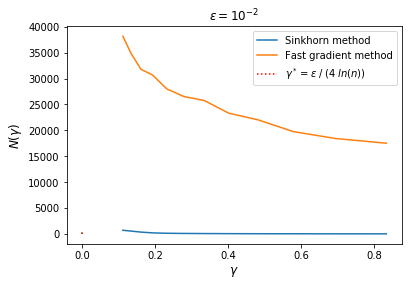

In [18]:
plt.title("$\epsilon = 10^{-2}$")
plt.xlabel("$\gamma$", fontsize=12)
plt.ylabel("$N(\gamma)$", fontsize=12)
plt.plot(gamma_exp, T_exp, label="Sinkhorn method")
plt.plot(gamma_exp, T_exp_, label="Fast gradient method")

plt.plot([p_, p_], [0, max(T_exp)], ':')
plt.plot([eps / (4 * np.log(N ** 2)), eps / (4 * np.log(N ** 2))], [0, max(T_exp)], 'r:', label="$\gamma^* = \epsilon\;/\;(4\;ln(n))$")
plt.legend()

plt.savefig('eps1e-2.eps', format='eps', dpi=1000)
plt.savefig("eps1e-2.png", dpi=1000)

In [73]:
eps1 = 1e-7
eps = 1e-3
gamma_exp, T_exp, opt_point = test_gamma(lambda gamma: sinkhorn(N ** 2, C, p, q, gamma, eps1, eps), gamma=1)
gamma_exp_, T_exp_, opt_point_ = test_gamma(lambda gamma: fastgrad(C, p, q, gamma, N ** 2, eps), gamma=1)

KeyboardInterrupt: 

In [68]:
p = 0

for i in range(1, len(gamma_exp)):
    if T_exp[i] > T_exp_[i] and T_exp[i-1] <= T_exp_[i-1]:
        p = 3/8 * gamma_exp[i] + 5/8 *  gamma_exp[i-1]

In [69]:
p

0.31396685313786016

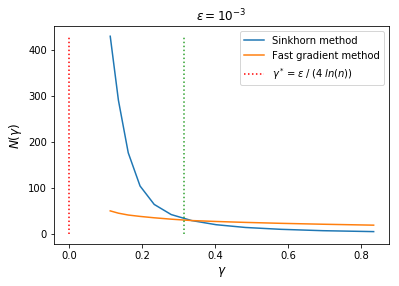

In [72]:
plt.title("$\epsilon = 10^{-3}$")
plt.xlabel("$\gamma$", fontsize=12)
plt.ylabel("$N(\gamma)$", fontsize=12)
plt.plot(gamma_exp, T_exp, label="Sinkhorn method")
plt.plot(gamma_exp, T_exp_, label="Fast gradient method")

plt.plot([p, p], [0, max(T_exp)], ':')
plt.plot([eps / (4 * np.log(N ** 2)), eps / (4 * np.log(N ** 2))], [0, max(T_exp)], 'r:', label="$\gamma^* = \epsilon\;/\;(4\;ln(n))$")
plt.legend()

plt.savefig('eps1e-3.eps', format='eps', dpi=1000)
plt.savefig("eps1e-3.png", dpi=1000)